In [1]:
import os
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn
import matplotlib.pyplot as pyplot
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow as tf
from sklearn.utils.class_weight import compute_class_weight
import pandas
import numpy
import wandb
from wandb.keras import WandbCallback

wandb.login(key='ea1404a9d16ac9056181f111599286f24c65e0e9')
wandb.init(project='covid19', entity='ashuto7h')
config = wandb.config

2021-11-12 18:45:23.692897: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
wandb: W&B API key is configured (use `wandb login --relogin` to force relogin)
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publically.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: ashuto7h (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.6 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
2021-11-12 18:45:32.857805: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0



CondaEnvException: Unable to determine environment

Please re-run this command with one of the following options:

* Provide an environment name via --name or -n
* Re-run this command inside an activated conda environment.



In [2]:
# ! pip install tensorflow --upgrade

In [3]:
sdir = r'../input/large-covid19-ct-slice-dataset/curated_data/curated_data'
filepaths = []
labels = []
classlist = os.listdir(sdir)
for item in classlist:
    classpath = os.path.join(sdir, item)
    flist = os.listdir(classpath)
    for f in flist:
        fpath = os.path.join(classpath, f)
        filepaths.append(fpath)
        labels.append(item)

df = pandas.DataFrame()
df['filepath'] = filepaths
df['labels'] = labels
print(df['labels'].value_counts())
df = df.sample(frac=1).reset_index(drop=True)

2COVID       7593
1NonCOVID    6893
3CAP         2618
Name: labels, dtype: int64


In [4]:
cw = compute_class_weight('balanced', classes=df.labels.unique(), y=df.labels)
print(cw, df.labels.unique())

[2.17774382 0.75086703 0.8271193 ] ['3CAP' '2COVID' '1NonCOVID']


In [5]:
class_weights = {2: 2.17774382, 0: 0.8271193, 1: 0.75086703}
class_map = {'2COVID': 1, '1NonCOVID': 0, '3CAP': 2}

In [6]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, df, batch_size=32, shuffle=True, color_mode="rgb"):
        self.batch_size = batch_size
        self.df = df
        self.indices = self.df.index.tolist()
        self.shuffle = shuffle
        self.on_epoch_end()
        self.color_mode = color_mode

    def __len__(self):
        return len(self.indices) // self.batch_size

    def __getitem__(self, index):
        index = self.index[index *
                           self.batch_size:(index + 1) *
                           self.batch_size]
        batch = [self.indices[k] for k in index]

        X, y = self.__get_data(batch)
        return X, y

    def on_epoch_end(self):
        self.index = numpy.arange(len(self.indices))
        if self.shuffle == True:
            numpy.random.shuffle(self.index)

    def __get_data(self, batch):
        X = []
        y = []
        for i, id in enumerate(batch):
            img = tf.keras.preprocessing.image.load_img(
                self.df.loc[id, 'filepath'],
                color_mode=self.color_mode,
                target_size=(256, 256),
                interpolation="nearest")
            img_array = tf.keras.preprocessing.image.img_to_array(img)
            X.append(img_array/255)
            ylist = [0, 0, 0]
            ylist[class_map[self.df.loc[id, 'labels']]] = 1
            ylist = numpy.array(ylist)
            y.append(ylist)
        X = numpy.array(X)
        y = numpy.array(y)
        return X, y

In [7]:
train_data = DataGenerator(df[:13684].reset_index(drop=True))  # 80%
valid_data = DataGenerator(df[13684:15394].reset_index(drop=True))  # 80 - 90%
test_data = DataGenerator(df[15394:].reset_index(drop=True), shuffle=False)  # 90 - 100%

# train_data = DataGenerator(df[:200].reset_index(drop=True))  # 80%
# valid_data = DataGenerator(df[200:300].reset_index(drop=True))  # 80 - 90%
# test_data = DataGenerator(df[300:400].reset_index(drop=True), shuffle=False)  # 90 - 100%

In [8]:
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, Dropout, BatchNormalization
def build_model():
    inputs = layers.Input(shape=(256, 256, 3))
    x = Xception(include_top=False, weights='imagenet', input_shape=(256,256,3))(inputs)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.3)(x)
    x = BatchNormalization()(x)
#     x = Dropout(0.3)(x)
#     x = BatchNormalization()(x)
    outputs = layers.Dense(3, activation="softmax")(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

In [9]:
initial_learning_rate = 0.015
epochs = 100
model_name = "Xception_v10.h5"
patience = 10
decay_steps = 100000
decay_rate = 0.96

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=decay_steps,
    decay_rate=decay_rate,
    staircase=True)
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    model_name,
    save_best_only=True)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    patience=patience,
    restore_best_weights=True)

In [10]:
config.class_weights = class_weights
config.class_map = class_map
config.initial_learning_rate = initial_learning_rate
config.epochs = epochs
config.model_name = model_name
config.patience = patience
config.decay_steps = decay_steps
config.decay_rate = decay_rate
# config.pooling = 'max'

In [11]:
model = build_model()
wandb.log({'model_summary': model.summary()})
METRICS = [
    tf.keras.metrics.CategoricalAccuracy(name="accuracy"),
    tf.keras.metrics.Precision(name="precision"),
    tf.keras.metrics.Recall(name="recall"),
]

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=METRICS
)

history = model.fit(
    train_data,
    epochs=epochs,
    class_weight=class_weights,
    verbose=1,
    validation_data=valid_data,
    workers=2,
    callbacks=[checkpoint_cb, early_stopping_cb, WandbCallback()],
)

2021-11-12 18:45:53.216861: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-11-12 18:45:53.219942: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-11-12 18:45:53.261257: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-12 18:45:53.261869: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.90GiB deviceMemoryBandwidth: 681.88GiB/s
2021-11-12 18:45:53.261929: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-11-12 18:45:53.290198: I tensorflow/stream_executor/platform/def

83689472/83683744 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
xception (Functional)        (None, 8, 8, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 2048)              8192      
_________________________________________________________________
dense (Dense)                (None, 3)                 6147      
Total params: 20,875,819
Trainable params: 20,817,195
Non-trai

2021-11-12 18:45:58.094327: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-11-12 18:45:58.098083: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2000189999 Hz


Epoch 1/100


2021-11-12 18:46:02.838937: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2021-11-12 18:46:03.829537: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2021-11-12 18:46:03.869756: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8


427/427 [==============================] - 248s 554ms/step - loss: 1.3939 - accuracy: 0.4015 - precision: 0.4387 - recall: 0.2592 - val_loss: 42.0770 - val_accuracy: 0.2995 - val_precision: 0.3081 - val_recall: 0.2565
Epoch 2/100
427/427 [==============================] - 227s 531ms/step - loss: 1.0907 - accuracy: 0.5160 - precision: 0.5481 - recall: 0.4140 - val_loss: 519.2080 - val_accuracy: 0.3019 - val_precision: 0.2756 - val_recall: 0.1875
Epoch 3/100
427/427 [==============================] - 227s 532ms/step - loss: 1.0100 - accuracy: 0.5217 - precision: 0.5622 - recall: 0.4323 - val_loss: 311.8063 - val_accuracy: 0.3520 - val_precision: 0.3385 - val_recall: 0.2954
Epoch 4/100
427/427 [==============================] - 228s 534ms/step - loss: 0.8610 - accuracy: 0.5487 - precision: 0.6143 - recall: 0.4414 - val_loss: 1.0530 - val_accuracy: 0.4629 - val_precision: 0.4644 - val_recall: 0.4617
Epoch 5/100
427/427 [==============================] - 228s 533ms/step - loss: 0.7459 - acc

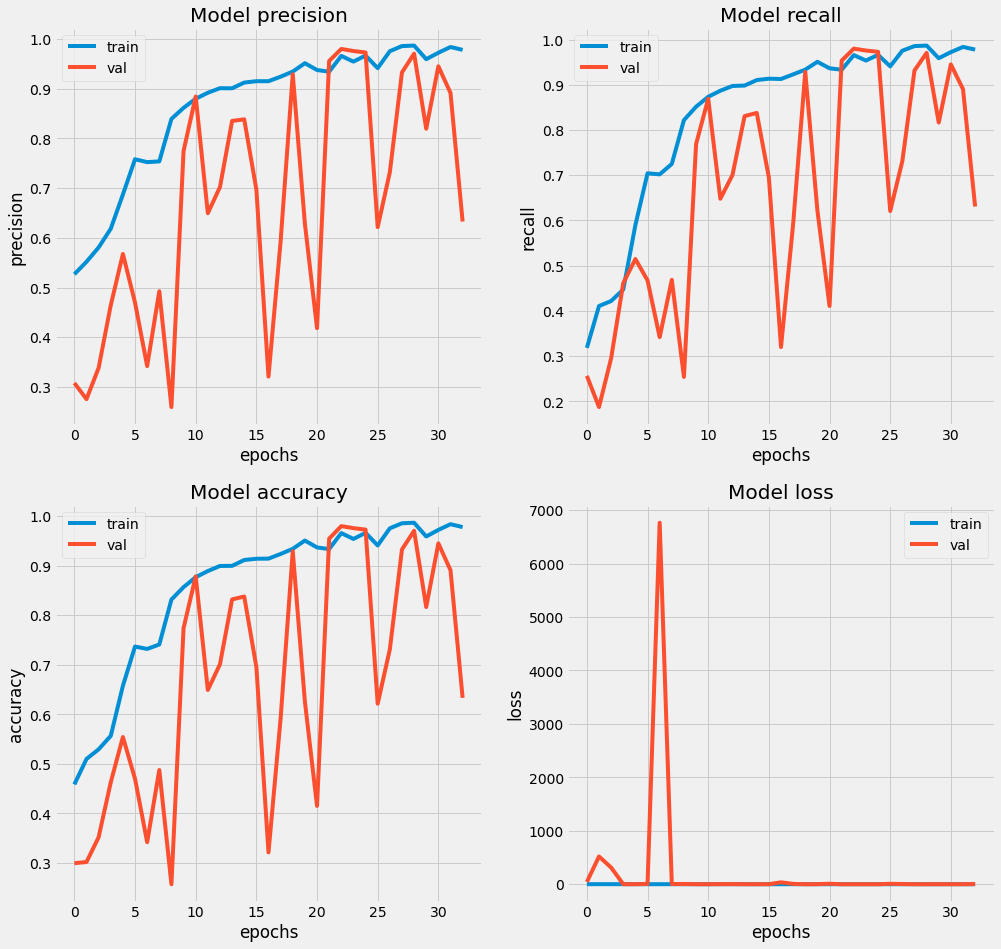

In [12]:
pyplot.style.use('fivethirtyeight')
fig, ax = pyplot.subplots(2, 2, figsize=(15, 15))
ax = ax.ravel()

for i, met in enumerate(["precision", "recall", "accuracy", "loss"]):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history["val_" + met])
    ax[i].set_title("Model {}".format(met))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(met)
    ax[i].legend(["train", "val"])
try:
    wandb.log({'training log img': wandb.Image(fig)})
except:
    pass

In [13]:
train_eval = model.evaluate(train_data, return_dict=True)
wandb.log({'train evaluation': train_eval})
display('train evaluation\n', train_eval)

valid_eval = model.evaluate(valid_data, return_dict=True)
wandb.log({'valid evaluation': valid_eval})
display('valid evaluation\n', valid_eval)

test_eval = model.evaluate(test_data, return_dict=True)
wandb.log({'test evaluation': test_eval})
display('test evaluation\n', test_eval)

427/427 [==============================] - 93s 218ms/step - loss: 0.0305 - accuracy: 0.9902 - precision: 0.9902 - recall: 0.9902


'train evaluation\n'

{'loss': 0.03053981252014637,
 'accuracy': 0.9901931881904602,
 'precision': 0.9901931881904602,
 'recall': 0.9901931881904602}

53/53 [==============================] - 11s 214ms/step - loss: 0.0575 - accuracy: 0.9800 - precision: 0.9800 - recall: 0.9800


'valid evaluation\n'

{'loss': 0.05746038630604744,
 'accuracy': 0.9799528121948242,
 'precision': 0.9799528121948242,
 'recall': 0.9799528121948242}

53/53 [==============================] - 21s 398ms/step - loss: 0.0617 - accuracy: 0.9776 - precision: 0.9776 - recall: 0.9776


'test evaluation\n'

{'loss': 0.06172674149274826,
 'accuracy': 0.9775943160057068,
 'precision': 0.9775943160057068,
 'recall': 0.9775943160057068}

In [14]:


def get_class(value):
    for key in class_map.keys():
        if class_map[key] == value:
            return key


get_class(2)

'3CAP'

### Confusion matrix - validation

53/53 [==============================] - 12s 221ms/step
              precision    recall  f1-score   support

           0       0.97      0.98      0.97       651
           1       0.98      0.97      0.98       786
           2       1.00      1.00      1.00       259

    accuracy                           0.98      1696
   macro avg       0.98      0.98      0.98      1696
weighted avg       0.98      0.98      0.98      1696



<AxesSubplot:>

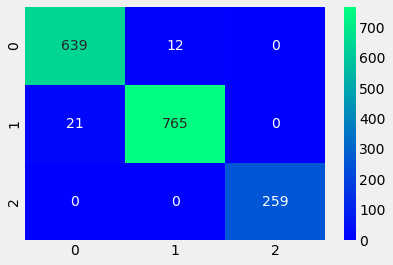

In [15]:

labels = []
for image, label in valid_data:
    labels.append(label)

labels = numpy.array(labels).reshape(-1, 3)
predictions = model.predict(valid_data, verbose=1)
labels = numpy.argmax(labels, axis=-1)
y_pred = numpy.argmax(predictions, axis=-1)

# get the classification report
cr = classification_report(labels, y_pred)
print(cr)
cm = confusion_matrix(labels, y_pred)
x = seaborn.heatmap(cm, cmap='winter', annot=True, fmt='d')
try:
    wandb.log({'confusion matrix valid img': wandb.Image(x)})
except:
    pass
display(x)

In [16]:

labels = []
for image, label in test_data:
    labels.append(label)

labels = numpy.array(labels).reshape(-1, 3)
predictions = model.predict(test_data, verbose=1)
labels = numpy.argmax(labels, axis=-1)
y_pred = numpy.argmax(predictions, axis=-1)

# get the classification report
cr = classification_report(labels, y_pred)
print(cr)

53/53 [==============================] - 11s 213ms/step
              precision    recall  f1-score   support

           0       0.96      0.99      0.97       684
           1       0.98      0.96      0.97       741
           2       1.00      0.99      1.00       271

    accuracy                           0.98      1696
   macro avg       0.98      0.98      0.98      1696
weighted avg       0.98      0.98      0.98      1696



<AxesSubplot:>

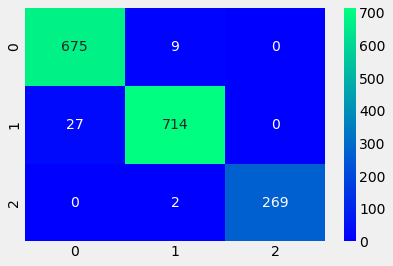

In [17]:
cm = confusion_matrix(labels, y_pred)
x = seaborn.heatmap(cm, cmap='winter', annot=True, fmt='d')
try:
    wandb.log({'confusion matrix test img': wandb.Image(x)})
except:
    pass
display(x)